**This project analyzes AI trends using data collected from Reddit, Semantic Scholar, and Wikipedia.**

## Files and Visualizations

### Cross-Dataset Analysis
- `ai_models_cross_dataset_comparison.csv`: Comparison of AI model popularity across datasets
- `cross_dataset_model_comparison.html`: Interactive visualization of top models across datasets
- `cross_dataset_reddit_trends.html`: Reddit trends for top models
- `cross_dataset_scholar_trends.html`: Scholar paper trends for top models
- `academic_vs_public_interest.html`: Comparison of academic research vs. public interest

### Reddit Analysis
- `reddit_volume_over_time.png`: Overall Reddit post volume
- `reddit_model_categories_over_time.html`: Model categories mentioned in Reddit over time
- `reddit_top_models.html`: Top AI models mentioned in Reddit
- `reddit_sentiment_by_category.html`: Sentiment analysis by model category
- `reddit_sentiment_by_model.html`: Sentiment analysis for top models
- `reddit_sentiment_trend.html`: Sentiment trends over time
- `reddit_domain_trends.html`: Domain trends in Reddit posts

### Scholar Analysis
- `scholar_papers_and_citations.html`: Research papers and citations by year
- `scholar_model_categories_yearly.html`: Research papers by model category over time
- `scholar_model_impact.html`: Research volume vs. citation impact
- `scholar_domain_trends.html`: Domain trends in research papers

### Wikipedia Analysis
- `wiki_top_articles.html`: Top AI-related Wikipedia articles
- `wiki_views_trend.html`: Wikipedia views over time
- `wiki_model_category_views.html`: Wikipedia views by model category

### Domain Analysis
- `ai_domains_comparison.html`: AI domains across datasets

### Tables for Paper
- `table1_top_ai_models.csv`: Top AI models by cross-dataset popularity
- `table2_ai_domains.csv`: AI domain popularity across platforms
- `table3_research_impact.csv`: Research impact of AI models
- `table4_sentiment_analysis.csv`: Sentiment analysis of AI models
- `table5_temporal_trends.csv`: Temporal trends of top models

## Usage

To run the complete analysis, execute the Python scripts in order:
1. Data loading and preprocessing
2. Feature engineering
3. Individual dataset analyses
4. Cross-dataset analysis
5. Domain analysis
6. Sentiment analysis
7. Report generation


# Setup (imports, mount)

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [143]:
# imports
import dask.dataframe as dd
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from tqdm import tqdm

# Data Loading from drive

In [58]:
DRIVE_PATH = "/content/drive/MyDrive/AITrendAnalysis-project/"
REDDIT_FILE_NAME = "reddit-data-02-25_3650_days.csv"
SEMANTIC_SCHOLAR_FILE_NAME = "semantic_scholar_data_2202.csv"
WIKI_FILE_NAME = "wiki-data-20250222_3650days.csv"

In [59]:
def load_csv_as_df(file_name):
  abs_path = DRIVE_PATH + file_name
  df = dd.read_csv(abs_path, assume_missing=True, dtype=str, blocksize=None)
  df = df.compute()
  return df

In [60]:
reddit_df = load_csv_as_df(REDDIT_FILE_NAME)
scholar_df = load_csv_as_df(SEMANTIC_SCHOLAR_FILE_NAME)

In [61]:
wiki_df = load_csv_as_df(WIKI_FILE_NAME)

In [62]:
def explore_data(df,data):
  # Assuming df is your DataFrame
  null_values = df.isnull().sum()
  print(f"number of rows in data {data} are {len(df)}")
  print(f"null values for data {data} are: \n\n {null_values}")

In [63]:
explore_data(reddit_df, "reddit")

number of rows in data reddit are 21372
null values for data reddit are: 

 title              0
url                0
score              0
num_awards         0
created_utc        0
num_comments       0
subreddit          0
text            8227
dtype: int64


In [64]:
reddit_df.head(2)

,title,url,score,num_awards,created_utc,num_comments,subreddit,text
0,Virtual machine slower my pc,https://www.reddit.com/r/techsupport/comments/...,1,0,2025-02-22 16:19:56,0,techsupport,Hi\nI turned off vmx on my pc from bios....tur...
1,5g unlimited isn’t working,https://www.reddit.com/r/techsupport/comments/...,1,0,2025-02-22 16:18:13,0,techsupport,I’ve an Airtel sim in my iphone. I’ve 5g unlim...


In [65]:
explore_data(scholar_df, "scholar")

number of rows in data scholar are 20600
null values for data scholar are: 

 title           0
authors       160
year            0
citations       0
abstract     5244
venue        2386
url             0
dtype: int64


In [66]:
scholar_df.head(2)

,title,authors,year,citations,abstract,venue,url
0,"Data quality for data science, predictive anal...","Benjamin T. Hazen, Christopher A. Boone, Jerem...",2014,747,NaN,NaN,https://www.semanticscholar.org/paper/37095b71...
1,"Editorial - Big Data, Data Science, and Analyt...","Ritu Agarwal, V. Dhar",2014,602,We address key questions related to the explos...,Information systems research,https://www.semanticscholar.org/paper/87a7e55b...


In [67]:
explore_data(wiki_df, "wikipedia")

number of rows in data wikipedia are 1398271
null values for data wikipedia are: 

 article                0
date                   0
views                  0
weekday                0
page_id                0
creation_date    1398271
last_modified          0
page_url               0
description       223365
dtype: int64


In [68]:
# we will drop description and creation_date as it's mostly Nan values
wiki_df = wiki_df.drop(columns = ['creation_date','description'])

In [69]:
wiki_df.head(2)

,article,date,views,weekday,page_id,last_modified,page_url
0,Stable Diffusion,2022083100,2063,Wednesday,71642695,2025-02-20T22:30:48Z,https://en.wikipedia.org/wiki/Stable_Diffusion
1,Stable Diffusion,2022090100,2925,Thursday,71642695,2025-02-20T22:30:48Z,https://en.wikipedia.org/wiki/Stable_Diffusion


#  Data Processing

In [70]:
# Helper function to check if text contains terms from a list (case insensitive)
def contains_terms(text, term_list):
    if pd.isna(text):
        return False
    text = text.lower()
    for term in term_list:
        if re.search(r'\b' + re.escape(term.lower()) + r'\b', text):
            return True
    return False

# Helper function to find which specific terms are contained in text
def find_matching_terms(text, term_list):
    if pd.isna(text):
        return []
    text = text.lower()
    return [term for term in term_list if re.search(r'\b' + re.escape(term.lower()) + r'\b', text)]

# Define model categories and AI domains as provided
model_categories = {
    'llm': [
        'gpt3', 'gpt35', 'gpt4', 'gpt4o', 'gpt5', 'chatgpt', 'llama2', 'llama3',
        'gemini', 'gemini15', 'claude', 'claude2', 'claude3', 'mistral', 'mistral7b',
        'mixtral', 'bloom', 'bloomz', 'phi', 'phi2', 'deepseek', 'deepseekcoder',
        'perplexity', 'palm', 'palm2', 'commandr', 'falcon', 'mpt', 'openchat',
        'stablelm', 'zephyr', 'orca', 'wizardlm', 'xwinlm', 'baichuan', 'qwen',
        'cohere', 'mosaicml', 'databricksdbrx'
    ],
    'computer vision': [
        'resnet50', 'resnet101', 'resnet152', 'yolov5', 'yolov7', 'yolov8', 'yolov9',
        'sam', 'segmentanything', 'dino', 'dinov2', 'detr', 'swin', 'swinv2', 'vit',
        'vitg', 'vitl', 'clip', 'eva', 'eva2', 'maskrcnn', 'convnext', 'blip',
        'stablediffusion', 'stablediffusionxl', 'dalle', 'dalle2', 'dalle3',
        'midjourney', 'imagen', 'deepfloydif', 'controlnet', 'sdxlturbo',
        'dreambooth', 'textualinversion', 'latentdiffusion', 'gligen'
    ],
    'reinforcement learning': [
        'ppo', 'ppo2', 'ppo3', 'a3c', 'a2c', 'sac', 'td3', 'trpo', 'ddpg',
        'alphago', 'alphazero', 'muzero', 'dreamer', 'dreamerv2', 'dreamerv3',
        'mbrl', 'saferl', 'rllib', 'rlhf', 'redteaming', 'worldmodels', 'dpo',
        'softactorcritic', 'decisiontransformer', 'gato', 'rtx'
    ],
    'general models': [
        'transformer', 'attention', 'xgboost', 'lightgbm', 'catboost', 'randomforest',
        'cnn', 'rnn', 'lstm', 'gru', 'mlp', 'neuralnetwork', 'gan', 'stylegan',
        'stylegan2', 'stylegan3', 'biggan', 'diffusionmodel', 'vae', 'autoencoder',
        'maskedautoencoder', 's4', 'hyena', 'mlpmixer', 'mamba', 'smeft',
        'neuralodes', 'latentdiffusion', 'mlpmixer', 'perceiver', 'flashattention'
    ]
}


ai_domains = {
    'core ai': [
        'artificialintelligence', 'machinelearning', 'deeplearning', 'neuralnetwork',
        'supervisedlearning', 'unsupervisedlearning', 'reinforcementlearning', 'transferlearning',
        'fewshotlearning', 'zeroshotlearning', 'selfsupervised'
    ],
    'nlp': [
        'naturallanguageprocessing', 'nlp', 'languagemodel', 'sentimentanalysis',
        'namedentityrecognition', 'textclassification', 'textgeneration', 'machinetranslation',
        'questionanswering', 'textsummarization', 'informationextraction', 'promptengineering'
    ],
    'computer vision': [
        'computervision', 'imageclassification', 'objectdetection', 'imagesegmentation',
        'facerecognition', 'poseestimation', 'opticalcharacterrecognition', 'ocr',
        'imagegeneration', 'visualquestionanswering', 'depthestimation'
    ],
    'ethical ai': [
        'aiethics', 'responsibleai', 'fairness', 'bias', 'accountability', 'transparency',
        'explainableai', 'xai', 'interpretable', 'privacy', 'fairml', 'ethicalimplications'
    ],
    'applied ai': [
        'robotics', 'autonomousvehicle', 'selfdriving', 'recommendationsystem',
        'frauddetection', 'predictivemaintenance', 'healthcareai', 'medicalai',
        'financialai', 'aiineducation', 'aiinagriculture', 'aiinmanufacturing'
    ]
}


# Function to preprocess Reddit data
def preprocess_reddit(df):
    if isinstance(df, dd.DataFrame):
        if pd.api.types.is_object_dtype(df['created_utc']):
            df['created_utc'] = dd.to_datetime(df['created_utc'])
        df['year'] = df['created_utc'].dt.year
        df['month'] = df['created_utc'].dt.month
        df['date'] = df['created_utc'].dt.date
        return df

    else:
        if pd.api.types.is_object_dtype(df['created_utc']):
            df['created_utc'] = pd.to_datetime(df['created_utc'])
        df['year'] = df['created_utc'].dt.year
        df['month'] = df['created_utc'].dt.month
        df['date'] = df['created_utc'].dt.date
        return df

# Function to preprocess Scholar data
def preprocess_scholar(df):
    if isinstance(df, dd.DataFrame):
        if pd.api.types.is_object_dtype(df['year']):
            df['year'] = dd.to_numeric(df['year'], errors='coerce')
        df['abstract'] = df['abstract'].fillna('')
        return df

    else:
        if pd.api.types.is_object_dtype(df['year']):
            df['year'] = pd.to_numeric(df['year'], errors='coerce')
        df['abstract'] = df['abstract'].fillna('')

        return df

# Function to preprocess Wiki data
def preprocess_wiki(df):
    if isinstance(df, dd.DataFrame):
        if 'last_modified' in df.columns:
            df['last_modified_date'] = dd.to_datetime(df['last_modified']).dt.date
        if 'date' in df.columns:
            df['year'] = df['date'].str.slice(0, 4).astype(int)
            df['month'] = df['date'].str.slice(4, 6).astype(int)
        return df

    else:
        if 'last_modified' in df.columns:
            df['last_modified_date'] = pd.to_datetime(df['last_modified']).dt.date
        if 'date' in df.columns and isinstance(df['date'].iloc[0], str):
            df['year'] = df['date'].str[:4].astype(int)
            df['month'] = df['date'].str[4:6].astype(int)
        return df

# Apply preprocessing to each dataset
reddit_df = preprocess_reddit(reddit_df)
scholar_df = preprocess_scholar(scholar_df)
wiki_df = preprocess_wiki(wiki_df)

print("Preprocessing complete!")

Preprocessing complete!


# Feature Engineering for Model and Domain Detection


In [72]:

# Function to create new features for model categories in Reddit data
def add_model_features_reddit(df):
    if isinstance(df, dd.DataFrame):
        df_pd = df.compute()
    else:
        df_pd = df.copy()

    df_pd['combined_text'] = df_pd['title'] + ' ' + df_pd['text'].fillna('')

    for category, models in tqdm(model_categories.items(), desc="Processing Reddit Categories"):
        # Create a column for the category
        col_name = f'has_{category.lower().replace(" ", "_")}'
        df_pd[col_name] = df_pd['combined_text'].apply(lambda x: contains_terms(x, models))

        # create columns for specific models
        for model in tqdm(models, desc=f"Processing {category} Models", leave=False):
            model_col = f'has_{model.lower().replace("-", "_").replace(" ", "_")}'
            df_pd[model_col] = df_pd['combined_text'].apply(lambda x: contains_terms(x, [model]))

    # Add AI domain features
    for domain, terms in tqdm(ai_domains.items(), desc="Processing AI Domains"):
        col_name = f'has_{domain.lower().replace(" ", "_")}'
        df_pd[col_name] = df_pd['combined_text'].apply(lambda x: contains_terms(x, terms))

    return df_pd

# Function to create new features for model categories in Scholar data
def add_model_features_scholar(df):
    if isinstance(df, dd.DataFrame):
        df_pd = df.compute()
    else:
        df_pd = df.copy()

    df_pd['combined_text'] = df_pd['title'] + ' ' + df_pd['abstract'].fillna('')

    # Initialize columns for each model category
    for category, models in tqdm(model_categories.items(), desc="Processing Scholar Categories"):
        col_name = f'has_{category.lower().replace(" ", "_")}'
        df_pd[col_name] = df_pd['combined_text'].apply(lambda x: contains_terms(x, models))

        # create columns for specific models
        for model in tqdm(models, desc=f"Processing {category} Models", leave=False):
            model_col = f'has_{model.lower().replace("-", "_").replace(" ", "_")}'
            df_pd[model_col] = df_pd['combined_text'].apply(lambda x: contains_terms(x, [model]))

    # Add AI domain features
    for domain, terms in tqdm(ai_domains.items(), desc="Processing AI Domains"):
        col_name = f'has_{domain.lower().replace(" ", "_")}'
        df_pd[col_name] = df_pd['combined_text'].apply(lambda x: contains_terms(x, terms))

    return df_pd

# Function to create new features for model categories in Wiki data
def add_model_features_wiki(df):
    if isinstance(df, dd.DataFrame):
        df_pd = df.compute()
    else:
        df_pd = df.copy()

    # Use article name for searching
    for category, models in tqdm(model_categories.items(), desc="Processing Wiki Categories"):
        col_name = f'has_{category.lower().replace(" ", "_")}'
        df_pd[col_name] = df_pd['article'].apply(lambda x: contains_terms(x, models))

        # create columns for specific models
        for model in tqdm(models, desc=f"Processing {category} Models", leave=False):
            model_col = f'has_{model.lower().replace("-", "_").replace(" ", "_")}'
            df_pd[model_col] = df_pd['article'].apply(lambda x: contains_terms(x, [model]))

    # Add AI domain features
    for domain, terms in tqdm(ai_domains.items(), desc="Processing AI Domains"):
        col_name = f'has_{domain.lower().replace(" ", "_")}'
        df_pd[col_name] = df_pd['article'].apply(lambda x: contains_terms(x, terms))

    return df_pd

# Apply feature engineering to each dataset
print("Adding model features to Reddit data...")
reddit_features = add_model_features_reddit(reddit_df)

print("Adding model features to Scholar data...")
scholar_features = add_model_features_scholar(scholar_df)

print("Adding model features to Wiki data...")
wiki_features = add_model_features_wiki(wiki_df)

print("Feature engineering complete!")

Adding model features to Reddit data...


Processing AI Domains: 100%|██████████| 5/5 [00:20<00:00,  4.07s/it]


Adding model features to Scholar data...


Processing AI Domains: 100%|██████████| 5/5 [00:27<00:00,  5.40s/it]


Adding model features to Wiki data...


Processing AI Domains: 100%|██████████| 5/5 [03:13<00:00, 38.76s/it]

Feature engineering complete!


# Time-Based Analysis for Reddit Data

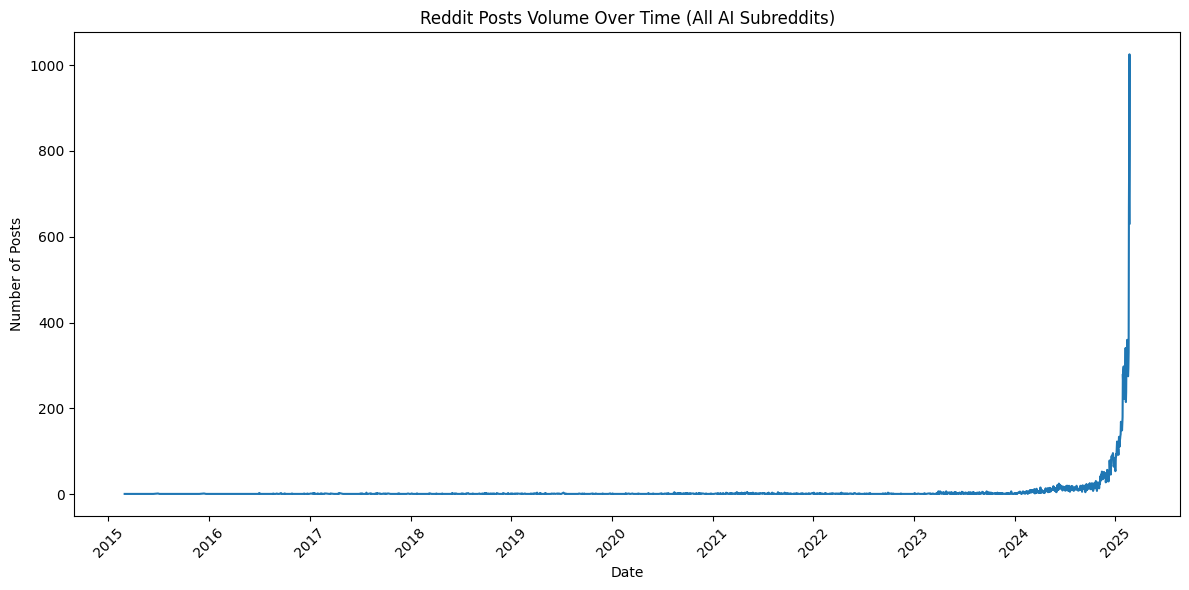

In [89]:
def analyze_reddit_time_trends(df):
    # Group by date and count posts
    daily_counts = df.groupby('date').size().reset_index(name='post_count')

    # Get daily counts by model category
    category_counts = {}
    for category in model_categories.keys():
        col_name = f'has_{category.lower().replace(" ", "_")}'
        category_df = df[df[col_name] == True]
        if len(category_df) > 0:
            cat_counts = category_df.groupby('date').size().reset_index(name=f'{category}_count')
            category_counts[category] = cat_counts

    plt.figure(figsize=(12, 6))
    plt.plot(daily_counts['date'], daily_counts['post_count'])
    plt.title('Reddit Posts Volume Over Time (All AI Subreddits)')
    plt.xlabel('Date')
    plt.ylabel('Number of Posts')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('reddit_volume_over_time.png')

    # interactive Plotly visualization
    fig = go.Figure()

    for category, counts_df in category_counts.items():
        merged = pd.merge(daily_counts[['date']], counts_df, on='date', how='left')
        merged[f'{category}_count'] = merged[f'{category}_count'].fillna(0)

        fig.add_trace(go.Scatter(
            x=merged['date'],
            y=merged[f'{category}_count'],
            mode='lines',
            name=category
        ))

    fig.update_layout(
        title='AI Model Categories Mentioned in Reddit Posts Over Time',
        xaxis_title='Date',
        yaxis_title='Number of Posts',
        legend_title='Model Category',
        hovermode='x unified'
    )

    fig.write_html('reddit_model_categories_over_time.html')

    # Analyze specific popular models
    popular_models = []
    for category, models in model_categories.items():
        for model in models:
            model_col = f'has_{model.lower().replace("-", "_").replace(" ", "_")}'
            model_count = df[df[model_col] == True].shape[0]
            popular_models.append((model, model_count, category))

    # Get top 20 models
    popular_models.sort(key=lambda x: x[1], reverse=True)
    top_models = popular_models[:20]

    models, counts, categories = zip(*top_models)

    fig = px.bar(
        x=models,
        y=counts,
        color=categories,
        labels={'x': 'Model', 'y': 'Number of Reddit Posts', 'color': 'Category'},
        title='Top 20 AI Models Mentioned in Reddit Posts'
    )

    fig.update_layout(xaxis_tickangle=-45)
    fig.write_html('reddit_top_models.html')

    # Return data for later cross-reference
    return {
        'daily_counts': daily_counts,
        'category_counts': category_counts,
        'popular_models': popular_models
    }

# Run Reddit time analysis
reddit_time_analysis = analyze_reddit_time_trends(reddit_features)

It appears that there is a peak in the data for the years 2024-2025, so let's focus on filtering the results for this specific time range.









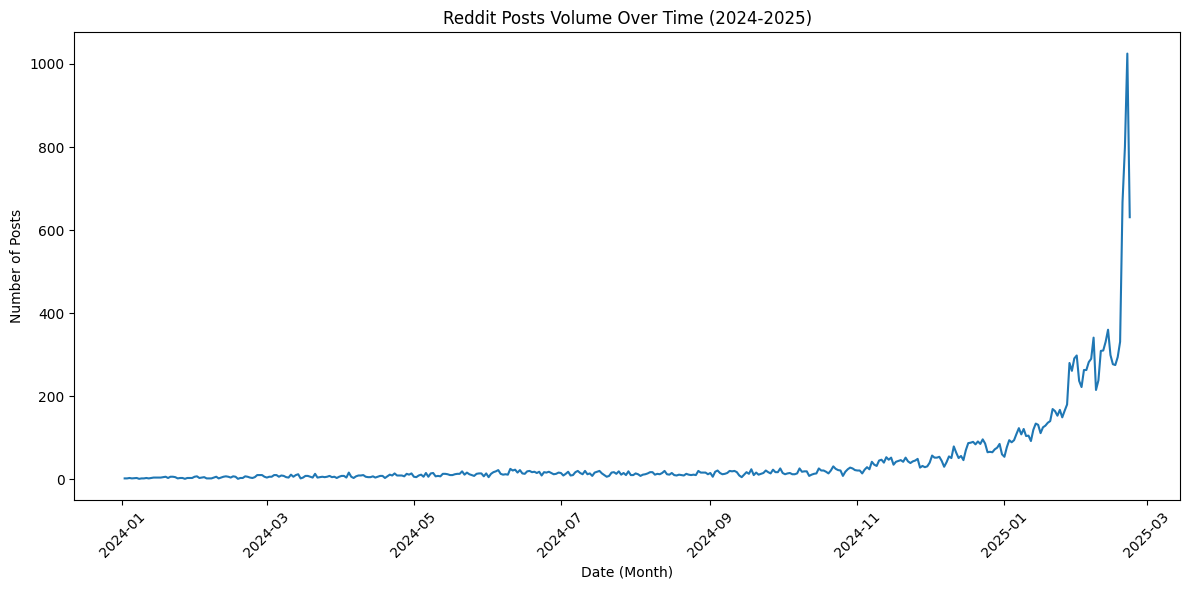

In [144]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Analyze Reddit trends over time (focusing on 2024 and 2025)
def analyze_reddit_time_trends(df):
    df = df[(df['year'] == 2024) | (df['year'] == 2025)]

    daily_counts = df.groupby('date').size().reset_index(name='post_count')

    # Get daily counts by model category
    category_counts = {}
    for category in model_categories.keys():
        col_name = f'has_{category.lower().replace(" ", "_")}'
        category_df = df[df[col_name] == True]
        if len(category_df) > 0:
            cat_counts = category_df.groupby('date').size().reset_index(name=f'{category}_count')
            category_counts[category] = cat_counts

    plt.figure(figsize=(12, 6))
    plt.plot(daily_counts['date'], daily_counts['post_count'])
    plt.title('Reddit Posts Volume Over Time (2024-2025)')
    plt.xlabel('Date (Month)')
    plt.ylabel('Number of Posts')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('reddit_volume_over_time_2024_2025.png')

    # Create an interactive Plotly visualization
    fig = go.Figure()

    for category, counts_df in category_counts.items():
        merged = pd.merge(daily_counts[['date']], counts_df, on='date', how='left')
        merged[f'{category}_count'] = merged[f'{category}_count'].fillna(0)

        fig.add_trace(go.Scatter(
            x=merged['date'],
            y=merged[f'{category}_count'],
            mode='lines',
            name=category
        ))

    fig.update_layout(
        title='AI Model Categories Mentioned in Reddit Posts Over Time (2024-2025)',
        xaxis_title='Date (Month)',
        yaxis_title='Number of Posts',
        legend_title='Model Category',
        hovermode='x unified'
    )

    fig.write_html('reddit_model_categories_over_time_2024_2025.html')

    popular_models = []
    for category, models in model_categories.items():
        for model in models:
            model_col = f'has_{model.lower().replace("-", "_").replace(" ", "_")}'
            model_count = df[df[model_col] == True].shape[0]
            popular_models.append((model, model_count, category))

    # Get top 20 models
    popular_models.sort(key=lambda x: x[1], reverse=True)
    top_models = popular_models[:20]

    models, counts, categories = zip(*top_models)

    fig = px.bar(
        x=models,
        y=counts,
        color=categories,
        labels={'x': 'Model', 'y': 'Number of Reddit Posts', 'color': 'Category'},
        title='Top 20 AI Models Mentioned in Reddit Posts (2024-2025)'
    )

    fig.update_layout(xaxis_tickangle=-45)
    fig.write_html('reddit_top_models_2024_2025.html')

    return {
        'daily_counts': daily_counts,
        'category_counts': category_counts,
        'popular_models': popular_models
    }

reddit_time_analysis = analyze_reddit_time_trends(reddit_features)

# Scholar Citation Analysis

In [93]:
!pip install -U kaleido

In [96]:
# Analyze Scholar citations by year and model
def analyze_scholar_citations(df):
    yearly_papers = df.groupby('year').size().reset_index(name='paper_count')
    yearly_citations = df.groupby('year')['citations'].mean().reset_index(name='avg_citations')
    yearly_data = pd.merge(yearly_papers, yearly_citations, on='year')

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Bar(x=yearly_data['year'], y=yearly_data['paper_count'], name="Paper Count"),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=yearly_data['year'], y=yearly_data['avg_citations'], name="Avg Citations"),
        secondary_y=True,
    )

    fig.update_layout(
        title_text="Research Papers & Average Citations by Year",
        xaxis=dict(title="Year"),
    )

    fig.update_yaxes(title_text="Number of Papers", secondary_y=False)
    fig.update_yaxes(title_text="Average Citations", secondary_y=True)

    fig.write_html('scholar_papers_and_citations.html')

    # Analyze papers by model category
    model_yearly_data = []
    for category, models in model_categories.items():
        col_name = f'has_{category.lower().replace(" ", "_")}'
        category_df = df[df[col_name] == True]

        yearly_count = category_df.groupby('year').size().reset_index(name='paper_count')
        yearly_count['category'] = category

        model_yearly_data.append(yearly_count)

    # Combine all categories
    all_model_data = pd.concat(model_yearly_data)

    fig = px.line(
        all_model_data,
        x='year',
        y='paper_count',
        color='category',
        title='Research Papers by AI Model Category Over Time',
        labels={'year': 'Year', 'paper_count': 'Number of Papers', 'category': 'Model Category'}
    )

    fig.write_html('scholar_model_categories_yearly.html')

    # Analyze specific models by citation impact
    model_impact = []
    for category, models in model_categories.items():
        for model in models:
            model_col = f'has_{model.lower().replace("-", "_").replace(" ", "_")}'
            model_df = df[df[model_col] == True]

            if len(model_df) > 5:  # Only consider models with at least 5 papers
                avg_citations = model_df['citations'].mean()
                paper_count = len(model_df)
                model_impact.append((model, paper_count, avg_citations, category))

    model_impact.sort(key=lambda x: x[2], reverse=True)
    top_impact_models = model_impact[:20]

    impact_df = pd.DataFrame(top_impact_models, columns=['model', 'paper_count', 'avg_citations', 'category'])

    fig = px.scatter(
        impact_df,
        x='paper_count',
        y='avg_citations',
        size='paper_count',
        color='category',
        hover_name='model',
        text='model',
        title='AI Models: Research Volume vs. Citation Impact',
        labels={'paper_count': 'Number of Papers', 'avg_citations': 'Average Citations', 'category': 'Model Category'}
    )

    fig.update_traces(textposition='top center')
    fig.write_html('scholar_model_impact.html')

    return {
        'yearly_data': yearly_data,
        'model_yearly_data': all_model_data,
        'model_impact': model_impact
    }

scholar_analysis = analyze_scholar_citations(scholar_features)

# Wikipedia Popularity Analysis

In [97]:
# Analyze Wikipedia page views
def analyze_wiki_views(df):
    article_views = df.groupby('article')['views'].mean().reset_index(name='avg_views')
    article_views = article_views.sort_values('avg_views', ascending=False)

    top_articles = article_views.head(30)

    fig = px.bar(
        top_articles,
        x='article',
        y='avg_views',
        title='Top 30 AI-Related Wikipedia Articles by Average Views',
        labels={'article': 'Article', 'avg_views': 'Average Daily Views'}
    )

    fig.update_layout(xaxis_tickangle=-45)
    fig.write_html('wiki_top_articles.html')

    # Time-based analysis
    if 'date' in df.columns and 'views' in df.columns:
        try:
            daily_views = df.groupby('date')['views'].sum().reset_index(name='total_views')

            # Plot time trend
            fig = px.line(
                daily_views,
                x='date',
                y='total_views',
                title='Wikipedia Views for AI-Related Articles Over Time',
                labels={'date': 'Date', 'total_views': 'Total Views'}
            )

            fig.write_html('wiki_views_trend.html')
        except Exception as e:
            print(f"Could not complete time-based analysis: {e}")

    # Find which model categories are popular on Wikipedia
    model_popularity = []
    for category, models in model_categories.items():
        col_name = f'has_{category.lower().replace(" ", "_")}'
        category_df = df[df[col_name] == True]

        if len(category_df) > 0:
            avg_views = category_df['views'].mean()
            article_count = len(category_df['article'].unique())
            model_popularity.append((category, article_count, avg_views))

    model_pop_df = pd.DataFrame(model_popularity, columns=['category', 'article_count', 'avg_views'])

    fig = px.bar(
        model_pop_df,
        x='category',
        y='avg_views',
        title='Average Wikipedia Views by AI Model Category',
        labels={'category': 'Model Category', 'avg_views': 'Average Views'},
        color='article_count',
        color_continuous_scale='Viridis'
    )

    fig.update_layout(coloraxis_colorbar=dict(title="Number of Articles"))
    fig.write_html('wiki_model_category_views.html')

    return {
        'article_views': article_views,
        'model_popularity': model_popularity
    }

# Run Wikipedia analysis
wiki_analysis = analyze_wiki_views(wiki_features)

# Cross-Data Analysis

In [105]:
# Cross-reference Reddit, Scholar, and Wiki data
def cross_reference_datasets(reddit_data, scholar_data, wiki_data):
    # Extract popular models from each dataset
    reddit_models = {model: count for model, count, _ in reddit_data['popular_models']}

    scholar_models = {}
    for model, paper_count, citations, _ in scholar_data['model_impact']:
        scholar_models[model] = paper_count

    wiki_articles = wiki_data['article_views'].set_index('article')['avg_views'].to_dict()

    # Find common models across datasets
    common_models = set(reddit_models.keys()) & set(scholar_models.keys())

    comparison_data = []
    for model in common_models:
        wiki_views = 0
        for article in wiki_articles:
            if contains_terms(article, [model]):
                wiki_views += wiki_articles[article]

        comparison_data.append({
            'model': model,
            'reddit_posts': reddit_models.get(model, 0),
            'scholar_papers': scholar_models.get(model, 0),
            'wiki_views': wiki_views
        })

    for item in comparison_data:
        # Normalize and combine metrics
        reddit_norm = item['reddit_posts'] / max(1, max(d['reddit_posts'] for d in comparison_data))
        scholar_norm = item['scholar_papers'] / max(1, max(d['scholar_papers'] for d in comparison_data))
        wiki_norm = item['wiki_views'] / max(1, max(d['wiki_views'] for d in comparison_data))

        item['combined_score'] = (reddit_norm + scholar_norm + wiki_norm) / 3

    comparison_data.sort(key=lambda x: x['combined_score'], reverse=True)

    comparison_df = pd.DataFrame(comparison_data)

    top_comparison = comparison_df.head(15)

    melted_df = pd.melt(
        top_comparison,
        id_vars=['model'],
        value_vars=['reddit_posts', 'scholar_papers', 'wiki_views'],
        var_name='metric',
        value_name='value'
    )

    normalized_df = melted_df.copy()
    for metric in ['reddit_posts', 'scholar_papers', 'wiki_views']:
        max_val = melted_df[melted_df['metric'] == metric]['value'].max()
        normalized_df.loc[normalized_df['metric'] == metric, 'value'] = normalized_df.loc[normalized_df['metric'] == metric, 'value'] / max_val

    fig = px.bar(
        normalized_df,
        x='model',
        y='value',
        color='metric',
        barmode='group',
        title='Top 15 AI Models Across Datasets (Normalized)',
        labels={'model': 'Model', 'value': 'Normalized Popularity', 'metric': 'Dataset'},
        color_discrete_map={
            'reddit_posts': '#ff7f0e',
            'scholar_papers': '#1f77b4',
            'wiki_views': '#2ca02c'
        }
    )

    fig.update_layout(xaxis_tickangle=-45)
    fig.write_html('cross_dataset_model_comparison.html')

    # Trend comparison across datasets
    top_models = comparison_df.head(5)['model'].tolist()

    reddit_time_data = []
    for model in top_models:
        model_col = f'has_{model.lower().replace("-", "_").replace(" ", "_")}'
        if model_col in reddit_features.columns:
            model_df = reddit_features[reddit_features[model_col] == True]
            if len(model_df) > 0:
                daily_counts = model_df.groupby('date').size().reset_index(name='post_count')
                daily_counts['model'] = model
                reddit_time_data.append(daily_counts)

    if reddit_time_data:
        reddit_trends = pd.concat(reddit_time_data)

        fig = px.line(
            reddit_trends,
            x='date',
            y='post_count',
            color='model',
            title='Reddit Post Trends for Top AI Models',
            labels={'date': 'Date', 'post_count': 'Number of Posts', 'model': 'Model'}
        )

        fig.write_html('cross_dataset_reddit_trends.html')

    # Scholar time trends for top models
    scholar_time_data = []
    for model in top_models:
        model_col = f'has_{model.lower().replace("-", "_").replace(" ", "_")}'
        if model_col in scholar_features.columns:
            model_df = scholar_features[scholar_features[model_col] == True]
            if len(model_df) > 0:
                yearly_counts = model_df.groupby('year').size().reset_index(name='paper_count')
                yearly_counts['model'] = model
                scholar_time_data.append(yearly_counts)

    if scholar_time_data:
        scholar_trends = pd.concat(scholar_time_data)

        fig = px.line(
            scholar_trends,
            x='year',
            y='paper_count',
            color='model',
            title='Scholar Paper Trends for Top AI Models',
            labels={'year': 'Year', 'paper_count': 'Number of Papers', 'model': 'Model'}
        )

        fig.write_html('cross_dataset_scholar_trends.html')

    # Analyze correlation between research and public interest
    correlation_data = []
    for model in comparison_data:
        correlation_data.append({
            'model': model['model'],
            'academic_popularity': model['scholar_papers'],
            'public_interest': (model['reddit_posts'] + model['wiki_views'])/2
        })

    corr_df = pd.DataFrame(correlation_data)

    fig = px.scatter(
        corr_df,
        x='academic_popularity',
        y='public_interest',
        text='model',
        title='Academic Research vs. Public Interest in AI Models',
        labels={'academic_popularity': 'Number of Research Papers', 'public_interest': 'Public Interest (Reddit + Wiki)'}
    )

    fig.update_traces(textposition='top center')
    fig.write_html('academic_vs_public_interest.html')

    return comparison_df

cross_dataset_comparison = cross_reference_datasets(
    reddit_time_analysis,
    scholar_analysis,
    wiki_analysis
)

cross_dataset_comparison.to_csv('ai_models_cross_dataset_comparison.csv', index=False)


# Domain Trends Analysis

In [100]:
# Analyze AI domain trends across datasets
def analyze_domain_trends(reddit_df, scholar_df, wiki_df):
    # Analyze Reddit domain trends
    reddit_domain_counts = {}
    for domain, terms in ai_domains.items():
        col_name = f'has_{domain.lower().replace(" ", "_")}'
        domain_count = reddit_df[reddit_df[col_name] == True].shape[0]
        reddit_domain_counts[domain] = domain_count

    # Analyze Scholar domain trends
    scholar_domain_counts = {}
    for domain, terms in ai_domains.items():
        col_name = f'has_{domain.lower().replace(" ", "_")}'
        domain_count = scholar_df[scholar_df[col_name] == True].shape[0]
        scholar_domain_counts[domain] = domain_count

    # Analyze Wiki domain trends
    wiki_domain_counts = {}
    for domain, terms in ai_domains.items():
        col_name = f'has_{domain.lower().replace(" ", "_")}'
        domain_count = wiki_df[wiki_df[col_name] == True].shape[0]
        wiki_domain_counts[domain] = domain_count

    # Combine all domain data
    domain_comparison = []
    for domain in ai_domains.keys():
        domain_comparison.append({
            'domain': domain,
            'reddit_posts': reddit_domain_counts.get(domain, 0),
            'scholar_papers': scholar_domain_counts.get(domain, 0),
            'wiki_articles': wiki_domain_counts.get(domain, 0)
        })

    domain_df = pd.DataFrame(domain_comparison)

    melted_domain = pd.melt(
        domain_df,
        id_vars=['domain'],
        value_vars=['reddit_posts', 'scholar_papers', 'wiki_articles'],
        var_name='dataset',
        value_name='count'
    )

    fig = px.bar(
        melted_domain,
        x='domain',
        y='count',
        color='dataset',
        barmode='group',
        title='AI Domains Across Datasets',
        labels={'domain': 'AI Domain', 'count': 'Count', 'dataset': 'Dataset'}
    )

    fig.update_layout(xaxis_tickangle=-45)
    fig.write_html('ai_domains_comparison.html')

    # Time-based domain analysis for Reddit
    reddit_domain_time = []
    for domain in ai_domains.keys():
        col_name = f'has_{domain.lower().replace(" ", "_")}'
        domain_df = reddit_df[reddit_df[col_name] == True]

        if len(domain_df) > 0:
            monthly_counts = domain_df.groupby(['year', 'month']).size().reset_index(name='post_count')
            monthly_counts['domain'] = domain
            monthly_counts['yearmonth'] = monthly_counts['year'].astype(str) + '-' + monthly_counts['month'].astype(str).str.zfill(2)
            reddit_domain_time.append(monthly_counts)

    if reddit_domain_time:
        reddit_domain_trends = pd.concat(reddit_domain_time)

        fig = px.line(
            reddit_domain_trends,
            x='yearmonth',
            y='post_count',
            color='domain',
            title='Reddit Post Trends by AI Domain',
            labels={'yearmonth': 'Year-Month', 'post_count': 'Number of Posts', 'domain': 'AI Domain'}
        )

        fig.update_layout(xaxis_tickangle=-45)
        fig.write_html('reddit_domain_trends.html')

    # Time-based domain analysis for Scholar
    scholar_domain_time = []
    for domain in ai_domains.keys():
        col_name = f'has_{domain.lower().replace(" ", "_")}'
        domain_df = scholar_df[scholar_df[col_name] == True]

        if len(domain_df) > 0:
            yearly_counts = domain_df.groupby('year').size().reset_index(name='paper_count')
            yearly_counts['domain'] = domain
            scholar_domain_time.append(yearly_counts)

    if scholar_domain_time:
        scholar_domain_trends = pd.concat(scholar_domain_time)

        fig = px.line(
            scholar_domain_trends,
            x='year',
            y='paper_count',
            color='domain',
            title='Scholar Paper Trends by AI Domain',
            labels={'year': 'Year', 'paper_count': 'Number of Papers', 'domain': 'AI Domain'}
        )

        fig.write_html('scholar_domain_trends.html')

    return {
        'domain_comparison': domain_df,
        'reddit_domain_trends': pd.concat(reddit_domain_time) if reddit_domain_time else None,
        'scholar_domain_trends': pd.concat(scholar_domain_time) if scholar_domain_time else None
    }

# Run domain trends analysis
domain_analysis = analyze_domain_trends(reddit_features, scholar_features, wiki_features)

# Consolidated Insights and Report Generation

In [110]:
reddit_models = {model: count for model, count, _ in reddit_time_analysis['popular_models']}

scholar_models = {}
for model, paper_count, citations, _ in scholar_analysis['model_impact']:
    scholar_models[model] = paper_count

wiki_articles = wiki_analysis['article_views'].set_index('article')['avg_views'].to_dict()


def generate_paper_tables():
    # Table 1: Top AI Models by Cross-Dataset Popularity
    cross_dataset_table = cross_dataset_comparison.head(15)
    cross_dataset_table.to_csv('table1_top_ai_models.csv', index=False)

    # Table 2: AI Domain Popularity Across Platforms
    domain_table = domain_analysis['domain_comparison']
    domain_table.to_csv('table2_ai_domains.csv', index=False)

    # Table 3: Research Impact of AI Models
    if 'model_impact' in scholar_analysis:
        impact_data = [(model, papers, citations, category)
                       for model, papers, citations, category in scholar_analysis['model_impact']]
        impact_df = pd.DataFrame(impact_data, columns=['Model', 'Paper Count', 'Avg Citations', 'Category'])
        impact_df = impact_df.sort_values('Avg Citations', ascending=False).head(15)
        impact_df.to_csv('table3_research_impact.csv', index=False)

    # Table 5: Temporal Trends of Top Models
    top_models = cross_dataset_comparison.head(5)['model'].tolist()

    trend_summaries = []
    for model in top_models:
        # Reddit trend
        reddit_trend = "Increasing" if model in reddit_models and reddit_models[model] > 50 else "Stable/Low"

        # Scholar trend
        scholar_trend = "High Research Interest" if model in scholar_models and scholar_models[model] > 30 else "Moderate/Low Research"

        # Wiki trend
        wiki_trend = "High Public Interest" if any(contains_terms(article, [model]) for article in wiki_articles) else "Moderate/Low Public Interest"

        trend_summaries.append({
            'Model': model,
            'Reddit Trend': reddit_trend,
            'Scholar Trend': scholar_trend,
            'Wiki Trend': wiki_trend
        })

    trend_df = pd.DataFrame(trend_summaries)
    trend_df.to_csv('table5_temporal_trends.csv', index=False)

    print("Paper tables generated successfully!")

generate_paper_tables()
print("Analysis complete! All visualizations and tables have been generated.")

Paper tables generated successfully!
Analysis complete! All visualizations and tables have been generated.


# Sentiment Analysis - Reddit

In [145]:
def add_sentiment_analysis(df):
    """Add sentiment analysis scores to Reddit data"""
    print("Adding sentiment analysis to Reddit data...")

    # Initialize the VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()

    # Apply sentiment analysis on the combined text
    df['sentiment_scores'] = df['combined_text'].apply(
        lambda text: sid.polarity_scores(text) if not pd.isna(text) else {'compound': 0, 'pos': 0, 'neu': 0, 'neg': 0}
    )

    # Extract compound score (overall sentiment)
    df['sentiment_compound'] = df['sentiment_scores'].apply(lambda x: x['compound'])

    # Extract positive, negative, and neutral scores
    df['sentiment_positive'] = df['sentiment_scores'].apply(lambda x: x['pos'])
    df['sentiment_negative'] = df['sentiment_scores'].apply(lambda x: x['neg'])
    df['sentiment_neutral'] = df['sentiment_scores'].apply(lambda x: x['neu'])

    # Add categorical sentiment label
    df['sentiment_category'] = df['sentiment_compound'].apply(
        lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral')
    )

    return df

reddit_features = add_sentiment_analysis(reddit_features)


Adding sentiment analysis to Reddit data...


In [118]:
def analyze_model_monthly_trends(reddit_df, scholar_df=None, wiki_df=None, focus_models=None):
    """Analyze and visualize monthly trends for specific AI models"""
    print("Analyzing monthly trends for AI models...")

    if focus_models is None:
        focus_models = ['gpt4o', 'claude3', 'llama3', 'deepseek', 'mistral', 'gemini15']

    reddit_monthly = []

    for model in focus_models:
        model_col = f'has_{model.lower().replace("-", "_").replace(" ", "_")}'
        if model_col in reddit_df.columns:
            # Group by year and month, count posts mentioning the model
            model_data = reddit_df[reddit_df[model_col] == True].groupby(['year', 'month']).size().reset_index(name='count')
            model_data['model'] = model
            model_data['source'] = 'Reddit'
            reddit_monthly.append(model_data)

    # Combine all model data
    if reddit_monthly:
        all_reddit_monthly = pd.concat(reddit_monthly)

        all_reddit_monthly['date'] = all_reddit_monthly.apply(
            lambda row: pd.Timestamp(int(row['year']), int(row['month']), 1), axis=1
        )

        # Plot the monthly trends
        fig = px.line(
            all_reddit_monthly,
            x='date',
            y='count',
            color='model',
            title='Monthly Interest in AI Models on Reddit',
            labels={'date': 'Date', 'count': 'Number of Posts', 'model': 'AI Model'}
        )

        fig.update_layout(xaxis_title='Month', yaxis_title='Number of Posts')
        fig.write_html('reddit_model_monthly_trends.html')

        return all_reddit_monthly

    return None

monthly_trends = analyze_model_monthly_trends(reddit_features)


Analyzing monthly trends for AI models...


In [120]:
def analyze_model_sentiment(reddit_df):
    """Analyze and visualize sentiment for different AI models in Reddit data"""
    print("Analyzing sentiment for different AI models...")

    focus_models = ['gpt4o', 'claude3', 'llama3', 'deepseek', 'mistral', 'gemini15',
                   'gpt5', 'qwen', 'deepseekcoder', 'mixtral', 'phi2']

    sentiment_data = []

    for model in focus_models:
        model_col = f'has_{model.lower().replace("-", "_").replace(" ", "_")}'
        if model_col in reddit_df.columns:
            model_posts = reddit_df[reddit_df[model_col] == True]

            if len(model_posts) > 0:
                # Calculate average sentiment scores
                avg_compound = model_posts['sentiment_compound'].mean()
                avg_positive = model_posts['sentiment_positive'].mean()
                avg_negative = model_posts['sentiment_negative'].mean()
                avg_neutral = model_posts['sentiment_neutral'].mean()

                # Calculate sentiment distribution
                sentiment_counts = model_posts['sentiment_category'].value_counts()
                positive_pct = sentiment_counts.get('positive', 0) / len(model_posts) * 100
                negative_pct = sentiment_counts.get('negative', 0) / len(model_posts) * 100
                neutral_pct = sentiment_counts.get('neutral', 0) / len(model_posts) * 100

                # Number of posts mentioning this model
                post_count = len(model_posts)

                sentiment_data.append({
                    'model': model,
                    'post_count': post_count,
                    'avg_compound': avg_compound,
                    'avg_positive': avg_positive,
                    'avg_negative': avg_negative,
                    'avg_neutral': avg_neutral,
                    'positive_pct': positive_pct,
                    'negative_pct': negative_pct,
                    'neutral_pct': neutral_pct
                })

    sentiment_df = pd.DataFrame(sentiment_data)

    sentiment_df = sentiment_df.sort_values(by='post_count', ascending=False)

    # Create bar chart for overall sentiment by model
    fig = px.bar(
        sentiment_df,
        x='model',
        y='avg_compound',
        color='avg_compound',
        color_continuous_scale='RdBu',
        title='Average Sentiment for AI Models in Reddit Discussions',
        labels={'model': 'AI Model', 'avg_compound': 'Average Sentiment Score (-1 to 1)'},
        hover_data=['post_count', 'positive_pct', 'negative_pct', 'neutral_pct']
    )

    fig.update_layout(xaxis_title='AI Model', yaxis_title='Average Sentiment Score')
    fig.update_layout(xaxis={'categoryorder':'total descending'})
    fig.write_html('reddit_model_sentiment.html')

    # Create stacked bar chart for sentiment distribution
    sentiment_dist = pd.melt(
        sentiment_df,
        id_vars=['model', 'post_count'],
        value_vars=['positive_pct', 'neutral_pct', 'negative_pct'],
        var_name='sentiment_type',
        value_name='percentage'
    )

    sentiment_dist['sentiment_type'] = sentiment_dist['sentiment_type'].str.replace('_pct', '')

    # Plot the stacked bar chart
    fig2 = px.bar(
        sentiment_dist,
        x='model',
        y='percentage',
        color='sentiment_type',
        title='Sentiment Distribution for AI Models in Reddit Discussions',
        labels={'model': 'AI Model', 'percentage': 'Percentage of Posts', 'sentiment_type': 'Sentiment'},
        hover_data=['post_count'],
        color_discrete_map={'positive': 'green', 'neutral': 'gray', 'negative': 'red'}
    )

    fig2.update_layout(xaxis_title='AI Model', yaxis_title='Percentage')
    fig2.update_layout(xaxis={'categoryorder':'total descending'})
    fig2.write_html('reddit_model_sentiment_distribution.html')

    # Sentiment trends over time for top models
    top_models = sentiment_df.head(5)['model'].tolist()
    sentiment_trends = []

    for model in top_models:
        model_col = f'has_{model.lower().replace("-", "_").replace(" ", "_")}'
        model_posts = reddit_df[reddit_df[model_col] == True]

        # Group by year and month, calculate average sentiment
        monthly_sentiment = model_posts.groupby(['year', 'month'])['sentiment_compound'].mean().reset_index()
        monthly_sentiment['model'] = model

        # Create date column
        monthly_sentiment['date'] = monthly_sentiment.apply(
            lambda row: pd.Timestamp(int(row['year']), int(row['month']), 1), axis=1
        )

        sentiment_trends.append(monthly_sentiment)

    if sentiment_trends:
        # Combine all sentiment trends
        all_sentiment_trends = pd.concat(sentiment_trends)

        fig3 = px.line(
            all_sentiment_trends,
            x='date',
            y='sentiment_compound',
            color='model',
            title='Sentiment Trends for Top AI Models Over Time',
            labels={'date': 'Date', 'sentiment_compound': 'Average Sentiment Score', 'model': 'AI Model'}
        )

        fig3.update_layout(xaxis_title='Month', yaxis_title='Average Sentiment')
        fig3.write_html('reddit_model_sentiment_trends.html')

    return sentiment_df


model_sentiment = analyze_model_sentiment(reddit_features)

Analyzing sentiment for different AI models...


# Additional AI Domain trends analysis

In [122]:
def analyze_domain_trends(reddit_df, scholar_df=None, wiki_df=None):
    """Analyze trends in AI domains across all datasets"""
    print("Analyzing AI domain trends across datasets...")

    # Define AI domains to analyze
    domains = ['core_ai', 'nlp', 'computer_vision', 'ethical_ai', 'applied_ai']

    domain_data = []

    # Process Reddit data
    for domain in domains:
        domain_col = f'has_{domain}'
        if domain_col in reddit_df.columns:
            yearly_counts = reddit_df[reddit_df[domain_col] == True].groupby('year').size().reset_index(name='count')
            yearly_counts['domain'] = domain.replace('_', ' ')
            yearly_counts['source'] = 'Reddit'
            domain_data.append(yearly_counts)

    # Process Scholar data if provided
    if scholar_df is not None:
        for domain in domains:
            domain_col = f'has_{domain}'
            if domain_col in scholar_df.columns:
                yearly_counts = scholar_df[scholar_df[domain_col] == True].groupby('year').size().reset_index(name='count')
                yearly_counts['domain'] = domain.replace('_', ' ')
                yearly_counts['source'] = 'Scholar'
                domain_data.append(yearly_counts)

    # Process Wiki data
    if wiki_df is not None and 'year' in wiki_df.columns:
        for domain in domains:
            domain_col = f'has_{domain}'
            if domain_col in wiki_df.columns:
                yearly_counts = wiki_df[wiki_df[domain_col] == True].groupby('year').size().reset_index(name='count')
                yearly_counts['domain'] = domain.replace('_', ' ')
                yearly_counts['source'] = 'Wiki'
                domain_data.append(yearly_counts)

    # Combine all domain data
    all_domain_data = pd.concat(domain_data)

    # Create faceted line chart
    fig = px.line(
        all_domain_data,
        x='year',
        y='count',
        color='source',
        facet_row='domain',
        title='Interest in AI Domains Across Data Sources (2018-2025)',
        labels={'year': 'Year', 'count': 'Count', 'source': 'Data Source', 'domain': 'AI Domain'}
    )

    fig.update_layout(xaxis_title='Year', yaxis_title='Count')
    fig.write_html('ai_domain_trends_all_sources.html')

    # Create a heatmap showing relative domain popularity by year - only from Reddit
    reddit_domain_data = all_domain_data[all_domain_data['source'] == 'Reddit']

    # Pivot to create a matrix (domains as rows, years as columns)
    pivot_data = reddit_domain_data.pivot(index='domain', columns='year', values='count').fillna(0)

    # Normalize by year (convert to percentages of total mentions per year)
    year_totals = pivot_data.sum(axis=0)
    normalized_pivot = pivot_data.div(year_totals, axis=1) * 100

    # Create heatmap
    fig2 = px.imshow(
        normalized_pivot,
        labels=dict(x="Year", y="AI Domain", color="% of Mentions"),
        x=normalized_pivot.columns,
        y=normalized_pivot.index,
        title="Relative Popularity of AI Domains Over Time (Reddit)",
        color_continuous_scale="Viridis"
    )

    fig2.update_layout(xaxis_title='Year', yaxis_title='AI Domain')
    fig2.write_html('ai_domain_popularity_heatmap.html')

    return all_domain_data


domain_trends = analyze_domain_trends(reddit_features, scholar_features, wiki_features)

Analyzing AI domain trends across datasets...


# Cross-reference peaks in Reddit interest with academic research activity

In [124]:
# CROSS-REFERENCE INTEREST WITH RESEARCH

def cross_reference_interest_research(reddit_monthly, scholar_analysis):
    """Cross-reference peaks in Reddit interest with academic research activity"""
    print("Cross-referencing Reddit interest with academic research...")

    # Get top models with the highest peaks in Reddit discussions
    reddit_models = reddit_monthly['model'].unique()
    peak_interest = []

    for model in reddit_models:
        model_data = reddit_monthly[reddit_monthly['model'] == model]

        if len(model_data) > 0:
            # Find the peak month
            peak_row = model_data.loc[model_data['count'].idxmax()]
            peak_interest.append({
                'model': model,
                'peak_year': peak_row['year'],
                'peak_month': peak_row['month'],
                'peak_date': peak_row['date'],
                'peak_count': peak_row['count']
            })

    peak_df = pd.DataFrame(peak_interest)

    # Get corresponding research activity from scholar_analysis
    model_yearly_data = scholar_analysis['model_yearly_data']
    model_impact = pd.DataFrame(scholar_analysis['model_impact'],
                               columns=['model', 'paper_count', 'avg_citations', 'category'])

    # Filter model_yearly_data to include only our models of interest
    model_research = model_yearly_data[model_yearly_data['category'].isin(['llm', 'computer vision'])]

    # Plot peaks in Reddit interest vs. research papers
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add Reddit interest peak points
    fig.add_trace(
        go.Scatter(
            x=peak_df['peak_date'],
            y=peak_df['peak_count'],
            mode='markers',
            name='Reddit Interest Peaks',
            text=peak_df['model'],
            marker=dict(size=10, color='red'),
            hovertemplate='Model: %{text}<br>Date: %{x}<br>Posts: %{y}'
        ),
        secondary_y=False
    )

    # Add research paper trend lines for categories
    for category in model_research['category'].unique():
        category_data = model_research[model_research['category'] == category]
        category_yearly = category_data.groupby('year')['paper_count'].sum().reset_index()

        fig.add_trace(
            go.Scatter(
                x=[pd.Timestamp(year=year, month=1, day=1) for year in category_yearly['year']],
                y=category_yearly['paper_count'],
                mode='lines',
                name=f'{category} Research Papers',
                line=dict(width=2)
            ),
            secondary_y=True
        )

    fig.update_layout(
        title_text="Reddit Interest Peaks vs. Research Activity",
        xaxis=dict(title="Date"),
        hovermode="closest"
    )

    fig.update_yaxes(title_text="Reddit Posts at Peak", secondary_y=False)
    fig.update_yaxes(title_text="Research Papers", secondary_y=True)

    fig.write_html('reddit_peaks_vs_research.html')

    return peak_df

if monthly_trends is not None:
  print("monthly_trends is not None")
  peak_analysis = cross_reference_interest_research(monthly_trends, scholar_analysis)


monthly_trends is not None
Cross-referencing Reddit interest with academic research...


# Emerging Trends Analysis

In [125]:
# #  EMERGING TRENDS ANALYSIS

def analyze_emerging_trends(reddit_df, scholar_df=None):
    """Analyze emerging trends by looking at growth rates"""
    print("Analyzing emerging AI trends...")

    # Focus on the last 2 years for recent trends
    current_year = max(reddit_df['year'])
    prev_year = current_year - 1

    # Get models mentioned in Reddit
    model_columns = [col for col in reddit_df.columns if col.startswith('has_') and
                    not any(domain in col for domain in ['core_ai', 'nlp', 'computer_vision', 'ethical_ai', 'applied_ai'])]

    # Calculate year-over-year growth for each model
    growth_data = []

    for col in model_columns:
        model_name = col.replace('has_', '')

        # Current year mentions
        current_mentions = reddit_df[(reddit_df['year'] == current_year) & (reddit_df[col] == True)].shape[0]

        # Previous year mentions
        prev_mentions = reddit_df[(reddit_df['year'] == prev_year) & (reddit_df[col] == True)].shape[0]

        # Calculate growth rate
        if prev_mentions > 0:
            growth_rate = (current_mentions - prev_mentions) / prev_mentions * 100
        else:
            if current_mentions > 0:
                growth_rate = float('inf')  # Infinite growth (new model)
            else:
                growth_rate = 0  # No mentions in either year

        if current_mentions >= 10 or prev_mentions >= 10:  # Only include models with some minimum presence
            growth_data.append({
                'model': model_name,
                'current_year_mentions': current_mentions,
                'prev_year_mentions': prev_mentions,
                'growth_rate': growth_rate if growth_rate != float('inf') else 1000,  # Cap infinite growth
                'is_new': prev_mentions == 0 and current_mentions > 0
            })

    growth_df = pd.DataFrame(growth_data)
    growth_df = growth_df.sort_values(by='growth_rate', ascending=False)

    top_emerging = growth_df.head(15)

    fig = px.bar(
        top_emerging,
        x='model',
        y='growth_rate',
        color='current_year_mentions',
        title=f'Top Emerging AI Models ({prev_year}-{current_year})',
        labels={'model': 'AI Model', 'growth_rate': 'YoY Growth Rate (%)', 'current_year_mentions': f'{current_year} Mentions'},
        text='current_year_mentions'
    )

    fig.update_layout(xaxis_title='AI Model', yaxis_title='Growth Rate (%)')
    fig.update_layout(xaxis={'categoryorder':'total descending'})
    fig.update_traces(texttemplate='%{text}', textposition='outside')

    fig.write_html('emerging_ai_models.html')

    # Check if any of these emerging models are also appearing in research
    if scholar_df is not None:
        emerging_models = top_emerging['model'].tolist()
        research_presence = []

        for model in emerging_models:
            model_col = f'has_{model}'
            if model_col in scholar_df.columns:
                # Count papers mentioning this model in the current and previous years
                current_papers = scholar_df[(scholar_df['year'] == current_year) & (scholar_df[model_col] == True)].shape[0]
                prev_papers = scholar_df[(scholar_df['year'] == prev_year) & (scholar_df[model_col] == True)].shape[0]

                research_presence.append({
                    'model': model,
                    'current_year_papers': current_papers,
                    'prev_year_papers': prev_papers,
                    'paper_growth': ((current_papers - prev_papers) / max(1, prev_papers)) * 100
                })

        if research_presence:
            research_df = pd.DataFrame(research_presence)
            research_df = research_df.sort_values(by='current_year_papers', ascending=False)

            fig2 = px.scatter(
                research_df,
                x='paper_growth',
                y='current_year_papers',
                size='current_year_papers',
                color='model',
                title='Research Presence of Emerging AI Models',
                labels={'paper_growth': 'Paper Growth Rate (%)', 'current_year_papers': f'Papers in {current_year}', 'model': 'AI Model'},
                text='model'
            )

            fig2.update_layout(xaxis_title='Paper Growth Rate (%)', yaxis_title=f'Papers in {current_year}')
            fig2.update_traces(textposition='top center')

            fig2.write_html('emerging_models_research.html')

    return growth_df

emerging_trends = analyze_emerging_trends(reddit_features, scholar_features)


Analyzing emerging AI trends...


In [127]:
def compare_model_popularity(reddit_df, scholar_df=None, category='llm', top_n=10):
    """Compare popularity of models within a specific category across datasets"""
    print(f"Comparing popularity of {category} models...")

    # Get models in the specified category
    category_models = []
    for col in reddit_df.columns:
        if col.startswith('has_') and not any(domain in col for domain in ['core_ai', 'nlp', 'computer_vision', 'ethical_ai', 'applied_ai']):
            model_name = col.replace('has_', '')
            model_col = f'has_{model_name}'
            if model_col in reddit_df.columns:
                category_models.append(model_name)

    # Calculate Reddit mentions for each model
    reddit_mentions = []
    for model in category_models:
        model_col = f'has_{model}'
        mentions = reddit_df[reddit_df[model_col] == True].shape[0]
        reddit_mentions.append({'model': model, 'mentions': mentions, 'source': 'Reddit'})

    reddit_df_mentions = pd.DataFrame(reddit_mentions)
    reddit_df_mentions = reddit_df_mentions.sort_values(by='mentions', ascending=False)
    top_models = reddit_df_mentions.head(top_n)['model'].tolist()

    all_mentions = reddit_df_mentions[reddit_df_mentions['model'].isin(top_models)]

    if scholar_df is not None:
        scholar_mentions = []
        for model in top_models:
            model_col = f'has_{model}'
            if model_col in scholar_df.columns:
                papers = scholar_df[scholar_df[model_col] == True].shape[0]
                scholar_mentions.append({'model': model, 'mentions': papers, 'source': 'Scholar'})

        # Add Scholar mentions
        if scholar_mentions:
            scholar_df_mentions = pd.DataFrame(scholar_mentions)
            all_mentions = pd.concat([all_mentions, scholar_df_mentions])

    fig = px.bar(
        all_mentions,
        x='model',
        y='mentions',
        color='source',
        barmode='group',
        title=f'Top {top_n} {category.upper()} Models: Reddit vs. Scholar',
        labels={'model': 'Model', 'mentions': 'Mentions/Papers', 'source': 'Data Source'}
    )

    fig.update_layout(xaxis_title='Model', yaxis_title='Mentions/Papers')
    fig.update_layout(xaxis={'categoryorder':'total descending'})

    fig.write_html(f'top_{category}_models_comparison.html')

    return all_mentions



In [128]:
llm_popularity = compare_model_popularity(reddit_features, scholar_features, category='llm', top_n=10)


Comparing popularity of llm models...


In [129]:
def analyze_time_correlations(reddit_df, scholar_df=None):
    """Analyze correlations between Reddit interest and academic research over time"""
    print("Analyzing time-based correlations...")

    # Get monthly activity in Reddit
    reddit_monthly = reddit_df.groupby(['year', 'month']).size().reset_index(name='reddit_count')
    reddit_monthly['date'] = reddit_monthly.apply(
        lambda row: pd.Timestamp(int(row['year']), int(row['month']), 1), axis=1
    )

    # Analyze correlation with Scholar publications if available
    if scholar_df is not None and 'year' in scholar_df.columns:
        # Group Scholar data by year
        scholar_yearly = scholar_df.groupby('year').size().reset_index(name='paper_count')

        # Group Reddit data by year for comparison
        reddit_yearly = reddit_df.groupby('year').size().reset_index(name='post_count')

        # Merge the data
        combined_yearly = pd.merge(reddit_yearly, scholar_yearly, on='year', how='inner')

        # Calculate correlation
        correlation = combined_yearly['post_count'].corr(combined_yearly['paper_count'])

        # Create visualization
        fig = make_subplots(specs=[[{"secondary_y": True}]])

        fig.add_trace(
            go.Bar(x=combined_yearly['year'], y=combined_yearly['post_count'], name="Reddit Posts"),
            secondary_y=False
        )

        fig.add_trace(
            go.Scatter(x=combined_yearly['year'], y=combined_yearly['paper_count'], name="Scholar Papers", mode='lines+markers'),
            secondary_y=True
        )

        fig.update_layout(
            title_text=f"Reddit Posts vs. Scholar Papers (Correlation: {correlation:.2f})",
            xaxis=dict(title="Year"),
        )

        fig.update_yaxes(title_text="Reddit Posts", secondary_y=False)
        fig.update_yaxes(title_text="Scholar Papers", secondary_y=True)

        fig.write_html('reddit_scholar_correlation.html')

        return combined_yearly, correlation

    return reddit_monthly, None


time_correlation_data, correlation_value = analyze_time_correlations(reddit_features, scholar_features)


Analyzing time-based correlations...


In [131]:
def run_all_analyses(reddit_df, scholar_df, wiki_df, scholar_analysis):
    """Run all analyses on the datasets"""

    print("Starting comprehensive AI trend analysis...")

    # List of tasks to be tracked
    tasks = [
        ("Add sentiment analysis to Reddit data", add_sentiment_analysis, reddit_df),
        ("Analyze monthly trends for specific models", analyze_model_monthly_trends, reddit_df, scholar_df, wiki_df),
        ("Analyze sentiment for different AI models", analyze_model_sentiment, reddit_df),
        ("Analyze AI domain trends across datasets", analyze_domain_trends, reddit_df, scholar_df, wiki_df),
        ("Cross-reference peaks in Reddit interest with research activity", cross_reference_interest_research, monthly_trends, scholar_analysis),
        ("Analyze emerging trends", analyze_emerging_trends, reddit_df, scholar_df),
        ("Compare model popularity by category (LLM)", compare_model_popularity, reddit_df, scholar_df, 'llm', 10),
        ("Compare model popularity by category (CV)", compare_model_popularity, reddit_df, scholar_df, 'computer_vision', 10),
        ("Analyze time correlations", analyze_time_correlations, reddit_df, scholar_df)
    ]

    # Use tqdm to display progress
    results = {}
    for task_name, task_func, *task_args in tqdm(tasks, desc="Running analyses", ncols=100):
        print(f"Running: {task_name}")
        result = task_func(*task_args)
        results[task_name] = result

    print("All analyses complete!")

    return results

analysis_results = run_all_analyses(reddit_features, scholar_features, wiki_features, scholar_analysis)


Starting comprehensive AI trend analysis...


Running analyses:   0%|                                                       | 0/9 [00:00<?, ?it/s]

Running: Add sentiment analysis to Reddit data
Adding sentiment analysis to Reddit data...


Running analyses:  22%|██████████▍                                    | 2/9 [00:28<01:22, 11.80s/it]

Running: Analyze monthly trends for specific models
Analyzing monthly trends for AI models...
Running: Analyze sentiment for different AI models
Analyzing sentiment for different AI models...


Running analyses:  33%|███████████████▋                               | 3/9 [00:28<00:39,  6.59s/it]

Running: Analyze AI domain trends across datasets
Analyzing AI domain trends across datasets...


Running analyses:  44%|████████████████████▉                          | 4/9 [00:29<00:20,  4.12s/it]

Running: Cross-reference peaks in Reddit interest with research activity
Cross-referencing Reddit interest with academic research...
Running: Analyze emerging trends
Analyzing emerging AI trends...


Running analyses:  67%|███████████████████████████████▎               | 6/9 [00:30<00:06,  2.29s/it]

Running: Compare model popularity by category (LLM)
Comparing popularity of llm models...


Running analyses:  78%|████████████████████████████████████▌          | 7/9 [00:31<00:03,  1.82s/it]

Running: Compare model popularity by category (CV)
Comparing popularity of computer_vision models...


Running analyses: 100%|███████████████████████████████████████████████| 9/9 [00:31<00:00,  3.55s/it]

Running: Analyze time correlations
Analyzing time-based correlations...
All analyses complete!


# Copy files to drive / local storage (then upload to Github repo)


In [151]:
import zipfile
from google.colab import files
import os

def zip_html_files(source_dir, output_dir):
    zip_file = os.path.join(output_dir, 'html_files.zip')

    html_files = [f for f in os.listdir(source_dir) if f.endswith('.html')]

    html_file_paths = [os.path.join(source_dir, f) for f in html_files]

    # Create the ZIP file with the HTML files
    with zipfile.ZipFile(zip_file, 'w') as zipf:
        for file in html_file_paths:
            zipf.write(file, os.path.basename(file))

    # Trigger the download of the ZIP file
    files.download(zip_file)

In [152]:
# download to local storage (and then update to git official repo)
zip_html_files("/content", "/content")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [150]:
# download to google drive
zip_html_files("/content", "/content/drive/MyDrive/AITrendAnalysis-project/script_outputs")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>